<a href="https://colab.research.google.com/github/kkarimi62/InverseDesignMagneticFeAlloys/blob/main/MachineLearningAssignment_kkarimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phaseshift Technologies: Machine Learning Researcher Assignment

**Assignment Overview**: In this assignment, you are provided with a dataset containing information on soft magnetic alloys, including their compositions and two key properties: Magnetic Saturation (BS) and Curie Temperature (TC). Your task is to develop a machine learning-based strategy to predict both properties.

**Assignment Details**:

1. **Data Utilization**: You may utilize any features or apply any output transformations as part of your approach. Please ensure these are thoroughly detailed in your final report.

2. **Programming Language and Tools**: You can use any suitable libraries to solve this problem. Python is the preferred programming language.

3. **Evaluation Criteria**: While prediction accuracy is not our primary focus, we will evaluate how you approach this problem, including your methodology, assumptions, and analytical rigor.

4. **Specific Tasks**
- **Prediction**: Provide your prediction for the element "Fe" for both Magnetic Saturation (BS) and Curie Temperature (TC).
- **Multi-objective Optimization**: Investigate whether maximizing both BS and TC simultaneously using your machine learning models is possible.
  - Provide the Pareto front for this multi-objective optimization.
  - Suggest a few new alloy compositions based on your findings.


**Deliverables**:
- A brief report detailing your results, methodology, and assumptions. This report can be in
the form of a presentation, or a document—whichever format you believe best conveys
your findings.
- Your code and Jupyter notebook clearly showcasing your steps and findings.

**Optional Bonus Questions**: While these tasks are optional and not required for the interview, they provide a deeper insight of the projects we undertake at PhaseShift Technologies. If you choose to
work on these, please include all relevant code.

1. **Bayesian Optimization**:
- Using Bayesian Optimization, can you suggest new alloys that simultaneously
maximize BS and TC?
  - Please provide details about the strategy and methodology you employed.

2. **Uncertainty Quantification/ Sensitivity analysis**:
- Can you quantify the uncertainty in " BS" due to variations in "Fe" and "B"
compositions within the alloy "Fe83B9Si5P3"?
 - Given the current data, you may use a Bayesian strategy to obtain the
posterior distribution of the Fe composition.
 - Treat this as a one-dimensional problem where BS is a function of Fe
composition.
 - Utilize your ML model as an evaluator for the sampled values.

3. **Optimization with Constraints**:
- We are providing an additional dataset containing TX values. Can you refine your
optimization code from Task 1 to include a constraint that TX must stay between
600 to 800 K?
 - Provide the optimized alloy compositions that satisfy this constraint.
 - Provide the Pareto front considering this new constraint.

## Import/install libraries and define helper functions


In [ ]:
#--- uncomment if these libraries are already installed.
# !pip install shap
# !pip install optuna
# !pip install catboost
# !sudo apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

We import the following libraries:


In [ ]:
import os
import numpy as np

#--- data management
import pandas as pd

#--- upload files
from google.colab import files

#--- visulazation
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True})
import seaborn as sns

#--- sklearn for machine learning
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, ConstantKernel

#--- scipy
import scipy.stats as stats

#--- deep learning
import tensorflow as tf
tf.random.set_seed(123456)

#--- regression
from catboost import CatBoostRegressor

#--- feature importance
import shap

#--- text analysis
import re

#--- optimization
import optuna
from optuna.samplers import NSGAIISampler
import logging
optuna.logging.set_verbosity(optuna.logging.ERROR)

#--- suppress warnings
import warnings
warnings.filterwarnings('ignore')

We define the following helper functions/classes:


In [ ]:
def parse_string(input_str):
  """
  Regular expression to match elements and their associated values
  """
  pattern = re.findall(r"([A-Z][a-z]*)([0-9]*\.?[0-9]+)", input_str)

  # Convert matches into a dictionary
  element_dict = {element: float(value) for element, value in pattern}

  return element_dict


def train_model(X,Y,model,parameters,
              cv=3,random_state=123456, verbose=False,
                **kwargs
                ):
  """
  Train a model using GridSearchCV
  """

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=random_state)

  if verbose:
    print('Train set:', X_train.shape,  Y_train.shape)
    print('Test set:', X_test.shape,  Y_test.shape)

  scaler   = StandardScaler()
  model_cv = GridSearchCV(model,parameters,cv=cv)

  if kwargs.get('normalize',True):
    model_pl = Pipeline([('scaler', scaler), ('regressor', model_cv)])
  else:
    model_pl = Pipeline([('regressor', model_cv)])

  model_pl.fit(X_train, Y_train)

  if verbose:
    print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)

  yhat          = model_pl.predict(X_test)
  test_mse      = mean_squared_error(Y_test,yhat)
  test_rsq      = r2_score(Y_test,yhat)
  print("Test rmse:", test_mse**0.5)
  print("Test R2:", test_rsq)

  #--- plot
  plt.figure(figsize=(4, 4))
  plt.plot(Y_test,yhat,'o',ms=6,markerfacecolor='none',color='red',label='Test')
  plt.plot(Y_train,model_pl.predict(X_train),'s',ms=6,markerfacecolor='none',label='Training')
  xlin = np.linspace(min(Y),max(Y),10)
  plt.plot(xlin,xlin,'-.',color='black')
  plt.legend()
  plt.xlim(kwargs.get('xlim',None))
  plt.ylim(kwargs.get('ylim',None))
  plt.xlabel(kwargs.get('xlabel',None))
  plt.ylabel(kwargs.get('ylabel',None))
  plt.title(kwargs.get('title',None))

  return model_pl


def TrainDeepLearnedModel(X,Y,model,parameters,
               random_state=123456, verbose=False,
                save_filename='best_model.keras',
                **kwargs
                ):
  '''
  Train a deep learned model using Keras
  '''

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=random_state)

  if verbose:
    print('Train set:', X_train.shape,  Y_train.shape)
    print('Test set:', X_test.shape,  Y_test.shape)


  if verbose:
    model.summary()

  #--- training
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1),
                loss='mse')
  history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
            callbacks=[tf.keras.callbacks.ModelCheckpoint(save_filename, save_best_only=True)],
            epochs=1000, batch_size=128, verbose=0)

  if verbose:
    plt.figure(figsize=(4, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'],color='red')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.xscale('log')
    plt.yscale('log')

  model         = tf.keras.models.load_model(save_filename)
  yhat          = model.predict(X_test)
  test_mse      = mean_squared_error(Y_test,yhat)
  test_rsq      = r2_score(Y_test,yhat)
  print("Test rmse:", test_mse**0.5)
  print("Test R2:", test_rsq)

  #--- plot
  plt.figure(figsize=(4, 4))
  plt.plot(Y_test,yhat,'o',ms=6,markerfacecolor='none',color='red',label='Test')
  plt.plot(Y_train,model.predict(X_train),'s',ms=6,markerfacecolor='none',label='Training')
  xlin = np.linspace(min(Y),max(Y),10)
  plt.plot(xlin,xlin,'-.',color='black')
  plt.legend()
  plt.xlim(kwargs.get('xlim',None))
  plt.ylim(kwargs.get('ylim',None))
  plt.xlabel(kwargs.get('xlabel',None))
  plt.ylabel(kwargs.get('ylabel',None))
  plt.title(kwargs.get('title',None))


def is_pareto_efficient_max(costs):
    """
    Find the Pareto-efficient points for maximization.
    :param costs: An (n_points, n_costs) array of costs
    :return: A (n_points, ) boolean array, True if the point is Pareto-efficient
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0
    while next_point_index < len(costs):
        nondominated_point_mask = np.any(costs > costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index+1])
    is_pareto_efficient = np.zeros(n_points, dtype=bool)
    is_pareto_efficient[is_efficient] = True
    return is_pareto_efficient

def PlotParetoFront(f1, f2, **kwargs):
  """
  Plot the Pareto front
  args:
  f1: first objective
  f2: second objective
  return:
  pareto_mask: boolean array, True if the point is Pareto-efficient
  """
  if kwargs.get('zscore',False):
    f1 = stats.zscore(f1)
    f2 = stats.zscore(f2)

  corr = np.corrcoef(f1, f2)[0, 1]
  print(f"Correlation coefficient: {corr}")
  # Stack the objective arrays

  costs = np.vstack((f1, f2)).T

  # Find Pareto-efficient points for maximization
  pareto_mask = is_pareto_efficient_max(costs)

  # Extract the Pareto front
  pareto_front_f1 = f1[pareto_mask]
  pareto_front_f2 = f2[pareto_mask]

  # Sort the Pareto front points for plotting
  sorted_indices = np.argsort(pareto_front_f1)
  pareto_front_f1 = pareto_front_f1[sorted_indices]
  pareto_front_f2 = pareto_front_f2[sorted_indices]

  #--- Plot all points
  plt.figure(figsize=(4, 4))
  plt.plot(f1, f2,'o',ms=3,markerfacecolor='none',label="All points", alpha=kwargs.get('alpha',1.0))
  plt.plot(pareto_front_f1, pareto_front_f2, '-.',color='red', label="Pareto front")
  plt.xlabel(kwargs.get('xlabel',None))
  plt.ylabel(kwargs.get('ylabel',None))
  plt.xlim(kwargs.get('xlim',None))
  plt.ylim(kwargs.get('ylim',None))
  plt.title(kwargs.get('title',None)  )
  plt.grid(kwargs.get('grid',False))
  plt.legend()
  plt.show()

  return pareto_mask


def Sampling(models,num_trial, X_samples,percentage_q5, percentage_q95,
             verbose=False,
             ):

    """
    Sampling function for multi-objective optimization

    args
    ----------
    models: sklearn model
    num_trial: integer, number of trials
    X_samples: numpy ndarray, original feature matrix (i.e. from experimental data)
    percentage_q5: numpy ndarray, 5th percentile of each feature
    percentage_q95: numpy ndarray, 95th percentile of each feature

    return
    ----------
    x: list, sampled features
    tc: list, sampled target1
    bs: list, ndarray, sampled target2
    """

    count = 0
    tc    = []
    bs    = []
    x     = []
    ndime = len(feature_columns)
    ndime_elemental = len(elemental_features)
    while count < num_trial:
#      feature_vector    = np.array([np.random.uniform(percentage_q5[idime], percentage_q95[idime]) for idime  in range(ndime)]).reshape(1, -1)
      feature_vector    = np.array([np.random.choice(X_samples[:,idime]) for idime  in range(ndime)]).reshape(1, -1)
      #

      #--- Constraint: The sum of elemental parameters must be 100
      param_sum      = np.sum(feature_vector[0][:ndime_elemental])
      #--- penalty if the sum deviates from 1
      if np.isclose(param_sum, 100.0, atol=0.5):

      #--- prediction using the trained model
        x.append(feature_vector[0])
        tc.append(models[ 0 ].predict(feature_vector)[0])
        bs.append(models[ 1 ].predict(feature_vector)[0])
        count+=1
        if verbose:
          print(f'num accepted trials:{count}')
      else:
        continue
    return x, tc, bs


def PlotOptunaResults(study,**kwargs):
  """
  Plot the Pareto front

  args
  ----------
  study: instance of Optuna study

  return
  ----------
  df_pareto: dataframe, containing the pareto front points
  """

  #--- extract the values from the trials
  bs_values = []
  tc_values = []
  for trial in study.trials:
      if trial.values is not None:
          bs_values.append(trial.values[1])
          tc_values.append(trial.values[0])

  print(f'Number of accepted trials: {len(bs_values)}')

  plt.figure(figsize=(4, 4))
  plt.plot(tc_values, bs_values,'o',ms=3,markerfacecolor='none',alpha=kwargs.get('alpha',1.0))

  #--- Plotting the Pareto front
  pareto_front = study.best_trials

  bs_vals = [t.values[1] for t in pareto_front]
  tc_vals = [t.values[0] for t in pareto_front]
  x_vals  = np.c_[[list(map(lambda x:t.params.get(x),elemental_features)) for t in pareto_front]]
  df_pareto = pd.DataFrame(np.c_[x_vals,bs_vals,tc_vals],columns=elemental_features+'bs tc'.split())


  #--- sort
  data = pd.DataFrame(np.c_[tc_vals, bs_vals],columns=['tc','bs']).sort_values(by='tc')

  if kwargs.get('plot_pareto',True):
    plt.plot(data.iloc[:,0], data.iloc[:,1], '-.', color='red')

  #--- labels
  plt.title(kwargs.get('title',None))
  plt.ylabel(kwargs.get('ylabel',None))
  plt.xlabel(kwargs.get('xlabel',None))
  plt.xlim(kwargs.get('xlim',None))
  plt.ylim(kwargs.get('ylim',None))
  plt.grid(kwargs.get('grid',False))

  return df_pareto

## Load data & exploratory analysis


We load the datasets from `TCurieData.csv`, `BsData.csv`, and `TxData.xlsx`

 and explore their shape and data types.


In [ ]:
#--- Upload a file: uncomment if you are working from a local machine

#uploaded = files.upload()

In [ ]:
os.listdir()

['.config', 'TCurieData.csv', 'TxData.xlsx', 'BsData.csv', 'sample_data']

In [ ]:
#--- list of files to check
files = ['TCurieData.csv', 'BsData.csv', 'TxData.xlsx']

#---- Check if files exist
for file in files:
    if not os.path.exists(file):
        raise FileNotFoundError(f"The file '{file}' does not exist in the current directory.")

TCurieData = pd.read_csv('TCurieData.csv')
BsData     = pd.read_csv('BsData.csv')
TxData     = pd.read_excel('TxData.xlsx')


In [ ]:
TCurieData.head()

,Composition,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K)
0,Fe69.5Co0.5Mn10Mo5B15,0.0,0.00000,20.0,370.00000
1,Fe80Ni6Zr7Nb2B4Cu1,0.0,0.00000,20.0,374.00000
2,Fe90Zr7B3,3600.0,873.25952,20.0,388.64693
3,Fe69.5Co0.5Mn10Mo5B15,1800.0,723.00000,20.0,389.00000
4,Fe90Zr7B3,3600.0,822.85321,20.0,389.68647


In [ ]:
TCurieData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Composition                220 non-null    object 
 1   Annealing Time (s)         220 non-null    float64
 2   Annealing Temperature (K)  220 non-null    float64
 3   Thickness (mu m)           220 non-null    float64
 4   Tc (K)                     220 non-null    float64
dtypes: float64(4), object(1)
memory usage: 8.7+ KB


In [ ]:
BsData.head()

,Composition,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Bs (T)
0,Fe89Hf7Zr1B3,1800,648.94849,32.5,0.25986
1,Fe89Hf7Zr1B3,1800,598.73871,32.5,0.37538
2,Fe89Hf7Zr1B3,1800,748.61528,32.5,0.42974
3,Fe89Hf7Zr1B3,1800,698.78188,32.5,0.62454
4,Fe89Hf7Zr1B3,0,0.00000,32.5,0.64000


In [ ]:
BsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Composition                294 non-null    object 
 1   Annealing Time (s)         294 non-null    int64  
 2   Annealing Temperature (K)  294 non-null    float64
 3   Thickness (mu m)           294 non-null    float64
 4   Bs (T)                     294 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.6+ KB


Our datasets associated with magnetic saturation $B_s$ and Curie temperature $T_c$ consist of 294 and 220 observations, respectively. The correspoding features include `Composition`, `Annealing Time (s)`, `Annealing Temperature (K)`, and `Thickness (mu m)`. The targets are denoted by `Bs (T)` and `Tc (K)`. The data is well-organized and requires no cleaning or handling missing values or duplicates. As a starting point, let's explore statistical distributions and relationships within the data using the Seaborn pairplot functionality:

Text(0.5, 1.08, 'Tc dataset')

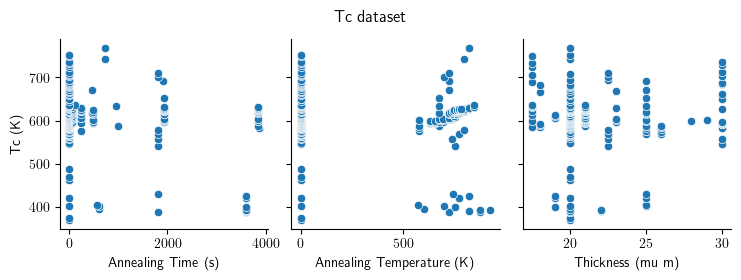

In [ ]:
g = sns.pairplot(data   = TCurieData,
                 x_vars = TCurieData.columns[1:-1],
                 y_vars = TCurieData.columns[-1])
g.fig.suptitle('Tc dataset', y=1.08)

Text(0.5, 1.0, 'Tc (K) distribution')

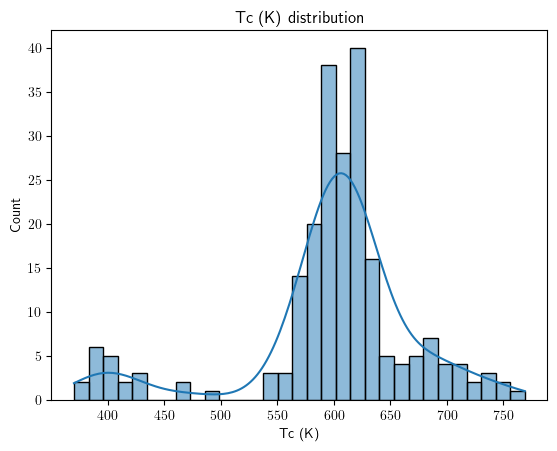

In [ ]:
g = sns.histplot(data=TCurieData,
                 x   ='Tc (K)',
                 kde =True)
g.set_title('Tc (K) distribution')

In [ ]:
round(TCurieData.describe().T,1)

,count,mean,std,min,25%,50%,75%,max
Annealing Time (s),220.0,743.3,1268.5,0.0,0.0,0.0,966.6,3857.0
Annealing Temperature (K),220.0,327.7,369.8,0.0,0.0,0.0,734.2,924.6
Thickness (mu m),220.0,21.7,3.4,17.5,20.0,20.0,22.5,30.0
Tc (K),220.0,599.2,73.8,370.0,587.0,606.0,626.8,769.0


The `Tc (K)` variable, representing Curie temperature, has a mean of $\simeq 600$ K and a standard deviation of $\simeq 74$ K, with temperatures ranging from 370 K to 769 K, suggesting a moderate spread across the samples.

Examining the scatter plots, it is not visually clear whether the processing parameters (i.e. `Annealing Time`, `Annealing Temperature`, and `Thickness`) have a significant impact on `Tc (K)`. The correlation coefficients provided below indicate negative correlations with `Annealing Time` and `Annealing Temperature`, suggesting potential anti-correlation effects. However, the overall magnitudes of these correlations are relatively low.

In [ ]:
print('Correlation coefficients')
TCurieData.corr(numeric_only=True).loc['Tc (K)'].iloc[:-1]

Correlation coefficients


,Tc (K)
Annealing Time (s),-0.247810
Annealing Temperature (K),-0.147637
Thickness (mu m),0.027035


Text(0.5, 1.08, 'Bs dataset')

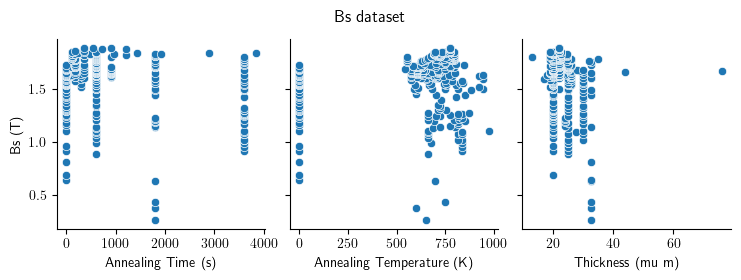

In [ ]:
g = sns.pairplot(data  =BsData,
                 x_vars=BsData.columns[1:-1],
                 y_vars=BsData.columns[-1])
g.fig.suptitle('Bs dataset', y=1.08)

Text(0.5, 1.0, 'Bs (T) distribution')

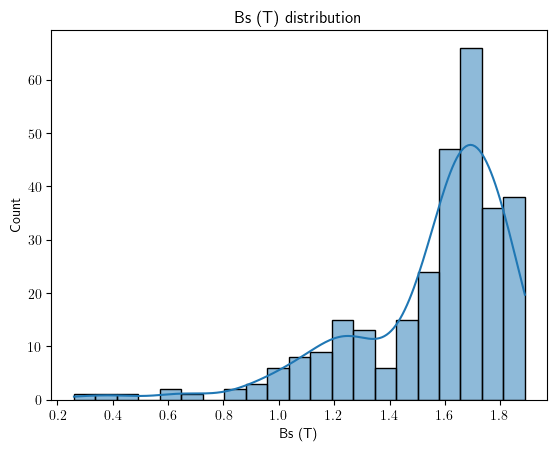

In [ ]:
g = sns.histplot(data=BsData,
                 x   ='Bs (T)',
                 kde =True)
g.set_title('Bs (T) distribution')

`Bs (T)` shows a moderate spread as well, with a mean value of 1.6 T and a standard deviation of 0.3 T, ranging from 0.3 T to 1.9 T.
`Annealing Time (s)` and `Thickness (mu m)` show weak negative correlations with `Bs`. On the other hand, `Annealing Temperature (K)` has a weak positive correlation with `Bs`, indicating that higher annealing temperatures might be associated with a slight increase in magnetic saturation. Overall, these correlations are very minimal, implying that the processing parameters might not have a notable influence on `Bs`.

In [ ]:
print('Correlation coefficients')
BsData.corr(numeric_only=True).loc['Bs (T)'].iloc[:-1]

Correlation coefficients


,Bs (T)
Annealing Time (s),-0.217252
Annealing Temperature (K),0.180172
Thickness (mu m),-0.218607


Regarding the processing parameters, `Annealing Time` ranges from 0 seconds up to an hour, with a significant portion of the samples having no annealing time, as indicated by the 25th quantile being 0. We note that approximately 30% of the samples, corresponding to `Annealing Time`=0 and `Annealing Temperature`=0, did not go through the annealing process. Apart from that, `Annealing Temperature` also shows a broad range, spanning from 500 K to approximately 1000 K.  `Thickness` has a mean of 22.5 μm and a standard deviation of 4.5 μm, ranging from 13 μm to 76 μm, indicating a relatively narrow distribution with some outliers.

In [ ]:
df_merged = pd.merge(TCurieData,
                     BsData,
                     on  = list(TCurieData.columns[:-1]),
                     how = 'outer')
round(df_merged[TCurieData.columns[1:-1]].describe().T,1)

,count,mean,std,min,25%,50%,75%,max
Annealing Time (s),489.0,935.6,1210.5,0.0,0.0,600.0,1800.0,3857.0
Annealing Temperature (K),489.0,497.6,337.3,0.0,0.0,660.0,748.5,973.0
Thickness (mu m),489.0,22.5,4.5,13.0,20.0,21.0,25.0,76.0


## Pre-processing and feature selection

Let's encode the alloy compositions using `class EncodeComposition`:

In [ ]:
class EncodeComposition:
  """
  return embedded compositions
  """

  def __init__(self):
    pass

  def Encode( self, composition, **kwargs ):

    #--- parse composition string to a dictionary
    #--- with element and molar ratio as key and val.
    parsed_dic          = composition.apply(lambda x: parse_string(x)).to_numpy()

    if not 'elements_dic' in kwargs:
      #--- unique set of elements
      elements_set        = set(np.concatenate(list(map(lambda x: list(x.keys()),parsed_dic))))
      #
      elements_list       = list( elements_set )
      elements_list.sort()
      nelem               = len( elements_list )
      elements_dic        = dict(zip(elements_list,range(nelem)))
    else:
      elements_dic        = kwargs['elements_dic']
      nelem               = len( elements_dic )
    #
    num_compositions      = len( parsed_dic )

    encoded_composition   = np.zeros( nelem * num_compositions ).reshape( ( num_compositions, nelem ) )

    #--- encoding
    for indx, comp in enumerate( parsed_dic ):
      for elem, x in comp.items():
        elem_indx                              = elements_dic[elem]
        encoded_composition[ indx, elem_indx ] = x

    filtr = np.isclose(encoded_composition.sum(axis=1),100.0,rtol=1e-04, atol=1e-02)
    if np.any( ~filtr ):
      print('warning: the following compositions do not add up to 100!')
      print(set(composition[~filtr]))

    #--- rescale to 100
    encoded_composition /= encoded_composition.sum(axis=1).reshape(-1,1)
    encoded_composition *= 100

    #--- inverse dictionary
    self.element_inverse = {v: k for k, v in elements_dic.items()}


    return encoded_composition, elements_dic


  def Decode( self, encoded_compositions, cutoff=1.0 ):
    if encoded_compositions.ndim == 1:
      encoded_comps = encoded_compositions.reshape(1,-1)
    else:
      encoded_comps = encoded_compositions
    return [''.join(['%s%2.1f'%(self.element_inverse[index],item) for index, item in enumerate(encoded_comp) if item >= cutoff]) for encoded_comp in encoded_comps]



Here is all the chemical elements within our dataset: Iron (Fe) + 28 alloying elements

In [ ]:
#--- fetch the element lists & combine
encode_comp         = EncodeComposition()
_, elements_dic     = encode_comp.Encode(TCurieData['Composition'])
_, elements_dic_2nd = encode_comp.Encode(BsData['Composition'])
_, elements_dic_3rd = encode_comp.Encode(TxData['Composition (at. %)'])
elements_list       = set(list(elements_dic.keys())+list(elements_dic_2nd.keys())+list(elements_dic_3rd.keys()))
elements_list       = list(elements_list)
elements_list.sort()
elements_combined   = dict(zip(elements_list,range(len(elements_list))))

{'Fe82Si5.2B11Nb3Cu0.8 ', 'Fe80Si6.2B12Nb3Cu0.8 ', 'Fe78Si7.2B13Nb3Cu0.8 '}
{'Co43.5Fe20Ta5.5B31.5'}


In [ ]:
elements_combined

{'Al': 0,
 'B': 1,
 'C': 2,
 'Co': 3,
 'Cr': 4,
 'Cu': 5,
 'Dy': 6,
 'Er': 7,
 'Fe': 8,
 'Ga': 9,
 'Gd': 10,
 'Ge': 11,
 'Hf': 12,
 'Mn': 13,
 'Mo': 14,
 'Nb': 15,
 'Nd': 16,
 'Ni': 17,
 'P': 18,
 'Pr': 19,
 'Sb': 20,
 'Si': 21,
 'Sm': 22,
 'Sn': 23,
 'Ta': 24,
 'Tb': 25,
 'V': 26,
 'Y': 27,
 'Zr': 28}

In [ ]:
#--- encoding
encoded_composition_T, _  = encode_comp.Encode(TCurieData['Composition'],elements_dic=elements_combined)
encoded_composition_B, _  = encode_comp.Encode(BsData['Composition'],elements_dic=elements_combined)
encoded_composition_Tx, _ = encode_comp.Encode(TxData['Composition (at. %)'],elements_dic=elements_combined)

{'Fe82Si5.2B11Nb3Cu0.8 ', 'Fe80Si6.2B12Nb3Cu0.8 ', 'Fe78Si7.2B13Nb3Cu0.8 '}
{'Co43.5Fe20Ta5.5B31.5'}


In [ ]:
encoded_composition_T.shape

(220, 29)

We reassign the encoded columns to the relevant dataframes.

In [ ]:
TCurieData_orig = TCurieData.copy()
BsData_orig     = BsData.copy()
TxData_orig     = TxData.copy()

TCurieData      = pd.concat([TCurieData,pd.DataFrame(encoded_composition_T, columns = elements_list)],axis=1)
BsData          = pd.concat([BsData,pd.DataFrame(encoded_composition_B,     columns = elements_list)],axis=1)
TxData          = pd.concat([TxData,pd.DataFrame(encoded_composition_Tx,    columns = elements_list)],axis=1)

In [ ]:
round(BsData,1).head()

,Composition,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Bs (T),Al,B,C,Co,Cr,...,Pr,Sb,Si,Sm,Sn,Ta,Tb,V,Y,Zr
0,Fe89Hf7Zr1B3,1800,648.9,32.5,0.3,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Fe89Hf7Zr1B3,1800,598.7,32.5,0.4,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Fe89Hf7Zr1B3,1800,748.6,32.5,0.4,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Fe89Hf7Zr1B3,1800,698.8,32.5,0.6,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Fe89Hf7Zr1B3,0,0.0,32.5,0.6,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Out of 28 alloying elements for Iron (`Fe`), we find Boron (`B`) and Silicon (`Si`) with relatively large (mean) elemental ratios.

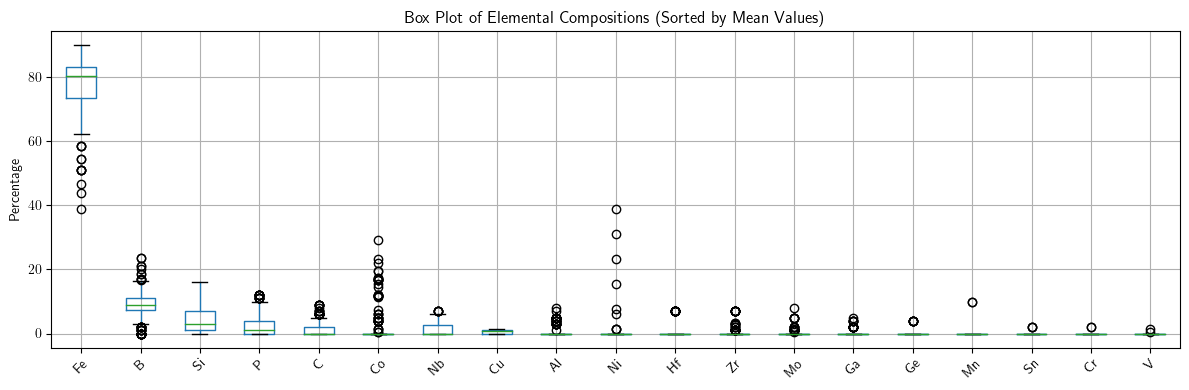

In [ ]:
columns         = list(TCurieData.columns)
columns.remove('Tc (K)')
df_merged       = pd.merge(TCurieData,BsData,on=columns,how='outer')

#--- calculate the mean for each column
element_columns = columns[4:]
mean_values     = df_merged[element_columns].mean()
mean_values     = mean_values[mean_values>0]

#--- sort the columns by mean values
sorted_columns  = mean_values.sort_values(ascending=False).index

plt.figure(figsize=(12, 4))
df_merged[sorted_columns].boxplot()
plt.title('Box Plot of Elemental Compositions (Sorted by Mean Values)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Together, we have 32 compositional and processing features.

In [ ]:
elemental_features  = elements_list
processing_features = ['Annealing Time (s)', 'Annealing Temperature (K)','Thickness (mu m)']
feature_columns     =  elemental_features + processing_features
print('number of feautures:',len(feature_columns))

number of feautures: 32


We note that `TxData` lacks the associated processing parameters. We will assign new columns to it using the median values from `TCurieData` and `BsData`.









In [ ]:
df_merged              = pd.merge(TCurieData,BsData,on=feature_columns,how='outer')
median_processing      = df_merged[processing_features].describe().T['50%'].to_numpy()
median_processing_tile = np.tile(median_processing, (TxData.shape[0],1))

TxData                 = pd.concat([TxData,pd.DataFrame(median_processing_tile, columns = processing_features)],axis=1)

mask                   = TxData['Tx/K']=='no'
TxData                 = TxData[~mask]

TxData.head()

,Composition (at. %),Bs/T,Tx/K,Al,B,C,Co,Cr,Cu,Dy,...,Sm,Sn,Ta,Tb,V,Y,Zr,Annealing Time (s),Annealing Temperature (K),Thickness (mu m)
0,Fe83Si2B11P3C1,1.67,727,0.0,11.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,660.0,21.0
1,Fe80P13C7,1.477,696,0.0,0.00,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,660.0,21.0
2,Fe80P11C9,1.37,720,0.0,0.00,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,660.0,21.0
3,Fe75B16.67Si8.33,1.57,839,0.0,16.67,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,660.0,21.0
4,Fe76C7.0Si3.3B5P8.7,1.52,795,0.0,5.00,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,660.0,21.0


Our correlation analysis indicates certain correlation patterns between `Tc` and various alloy elements.

In [ ]:
print('Correlation table:')
TCurieData.corr(numeric_only=True).loc['Tc (K)'][elemental_features].sort_values(ascending=False).dropna()

Correlation table:


,Tc (K)
Si,0.274614
B,0.260868
Ga,0.085022
Co,0.062514
C,0.050460
P,0.044819
Al,0.025195
Cu,-0.007975
Sn,-0.052286
Nb,-0.100489


Text(0.5, 1.08, 'Tc dataset')

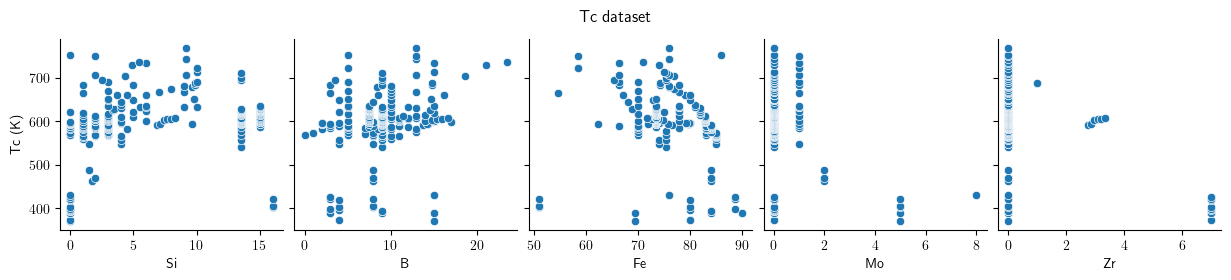

In [ ]:
g = sns.pairplot(data  =TCurieData,
                 x_vars='Si B Fe Mo Zr'.split(),
                 y_vars='Tc (K)')
g.fig.suptitle('Tc dataset', y=1.08)

Specifically, there are notable positive correlations between `Tc` and `Si`, as well as between `Tc` and `B`, indicating that increases in `Si` and `B` are associated with higher Curie temperatures. On the other hand, `Tc` exhibits negative correlations with `Fe`, suggesting that higher concentrations of this element is linked to lower Curie temperatures. Similar trends may be observed for Molybdenum (`Mo`) and Zirconium (`Zr`) although the estimated correlation factor could be biased due to an abundance of alloys with zero `Mo` and/or `Zr` content.

With regard to the magnetic saturation and various alloy elements, there are pronounced correlations between `Bs` and `Fe` as expected as well as Copper (`Cu`). A negative correlation between `Bs` and `Si` is also remarkable.

In [ ]:
print('Correlation table:')
BsData.corr(numeric_only=True).loc['Bs (T)'][elemental_features].sort_values(ascending=False).dropna()

Correlation table:


,Bs (T)
Fe,0.409937
Cu,0.243189
C,0.214694
B,0.203256
Co,-0.007784
Cr,-0.024024
P,-0.063855
Sn,-0.071084
Mo,-0.090413
Zr,-0.155561


Text(0.5, 1.08, 'Bc dataset')

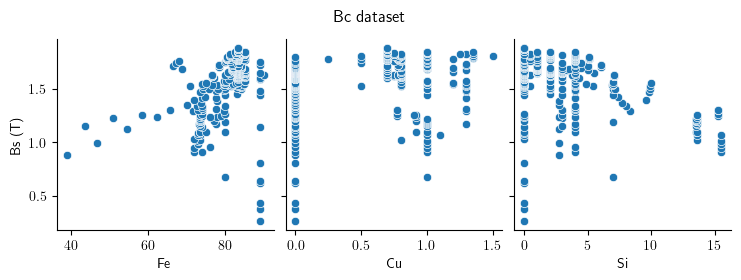

In [ ]:
g = sns.pairplot(data =BsData,
                 x_vars='Fe Cu Si'.split(),
                 y_vars='Bs (T)')
g.fig.suptitle('Bc dataset', y=1.08)

The above analysis might indicate  opposite trends in terms of the sensitivity of `Bs` and `Tc` with respect to `Fe` and `Si` content. That is to say increases in Fe enhance magnetic saturation and higher Si levels tends to reduce `Bs`, whereas increased `Fe` content lowers the Curie temperature and higher Si improves `Tc`. These contrasting trends may highlight a competing nature of `Bs` and `Tc`, making the simultaneous optimization of both properties a non-trivial task.

## Training & validation

In this analysis, we employ six different machine learning (ML) regressors including Ridge Regression, Support Vector Machine (SVM), Gaussian Process Regressor (GPR), CatBoost, K-Nearest Neighbors (KNN), and dense neural networks (denseNN) to predict the target variables (i.e. `Tc` and `Bs`) based on the compositional and processing features. To enhance model performance, we perform hyperparameter fine-tuning using `GridSearchCV` for each model. Cross-validation is performed with `cv=3` to ensure robust evaluation and avoid overfitting. The dataset is split into training and test sets, with a test size of 30%, and standardization is applied based on varaiables relevant to the training set to establish consistent feature scaling. Model performance is assessed using Root Mean Squared Error (RMSE) and R² metrics, which measure the accuracy and robustness of our predictions.









### Ridge

In [ ]:
parameters = {'alphas':np.logspace(-3, 3, 16)}
model      = RidgeCV()

Train set: (154, 560) (154,)
Test set: (66, 560) (66,)
tuned hpyerparameters :(best parameters)  {'alphas': 25.11886431509582}
Test rmse: 27.703085633995997
Test R2: 0.8466726125612352


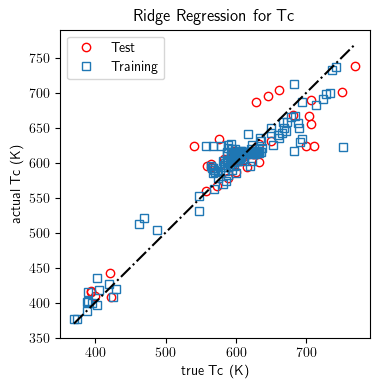

In [ ]:
X          = TCurieData[feature_columns].to_numpy()
Y          = TCurieData['Tc (K)'].to_numpy()

poly       = PolynomialFeatures(2,include_bias=False)
X          = poly.fit_transform(X)

ridge_tc   = train_model(X,Y,model,parameters,
                         verbose = True,
                         xlim    = [350,790],ylim    = [350,790],
                         xlabel  = 'true Tc (K)',ylabel  = 'actual Tc (K)',
                         title   = 'Ridge Regression for Tc'
                         )

Train set: (205, 560) (205,)
Test set: (89, 560) (89,)
tuned hpyerparameters :(best parameters)  {'alphas': 158.48931924611142}
Test rmse: 0.1482822198024337
Test R2: 0.7772074004603362


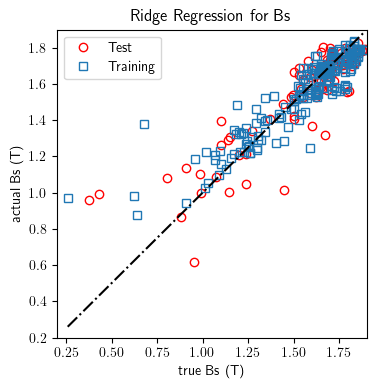

In [ ]:
X          = BsData[feature_columns].to_numpy()
Y          = BsData['Bs (T)'].to_numpy()

poly       = PolynomialFeatures(2,include_bias=False)
X          = poly.fit_transform(X)

ridge_bs   = train_model(X,Y,model,parameters,
                         verbose = True,
                         xlim    = [0.2,1.9],ylim    = [0.2,1.9],
                         xlabel  = 'true Bs (T)',ylabel  = 'actual Bs (T)',
                         title   = 'Ridge Regression for Bs')

### SVM


In [ ]:
parameters = {'kernel':['rbf'],
              'C': np.logspace(-5, 5, 11),
              'gamma':np.logspace(-4, 4, 9)}
model = SVR()

Train set: (154, 32) (154,)
Test set: (66, 32) (66,)
tuned hpyerparameters :(best parameters)  {'C': 10000.0, 'gamma': 0.01, 'kernel': 'rbf'}
Test rmse: 28.401225720026368
Test R2: 0.8388472898250151


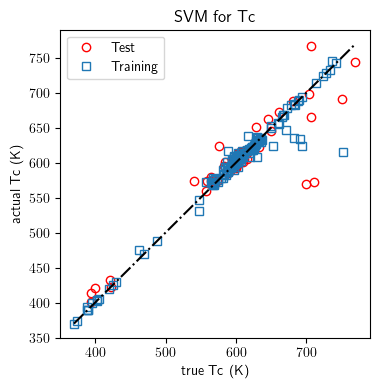

In [ ]:
svm_tc     = train_model( TCurieData[feature_columns].to_numpy(),
                          TCurieData['Tc (K)'].to_numpy(),
                          model,parameters,
                          verbose = True,
                          xlim    = [350,790],ylim    = [350,790],
                          xlabel  = 'true Tc (K)',ylabel  = 'actual Tc (K)',
                          title   = 'SVM for Tc'
                          )

Train set: (205, 32) (205,)
Test set: (89, 32) (89,)
tuned hpyerparameters :(best parameters)  {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Test rmse: 0.1435033417380778
Test R2: 0.7913364305630332


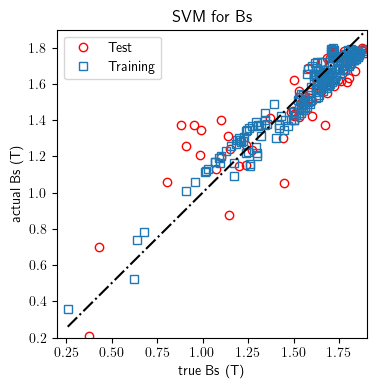

In [ ]:
svm_bs = train_model( BsData[feature_columns].to_numpy(),
                      BsData['Bs (T)'].to_numpy(),
                      model,parameters,
                      verbose = True,
                      xlim    = [0.2,1.9],ylim    = [0.2,1.9],
                      xlabel  = 'true Bs (T)',ylabel  = 'actual Bs (T)',
                      title   = 'SVM for Bs'
                     )


### GPR

In [ ]:
parameters = {
              'kernel': [
              ConstantKernel(10.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)),
              ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5),
              ConstantKernel(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=1.0),
              ConstantKernel(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0) ** 2,
              ],
              'alpha': np.logspace(-4,4,9),
              'n_restarts_optimizer': [5],
              'random_state':[123456],
              }

model     = GaussianProcessRegressor()

Train set: (154, 32) (154,)
Test set: (66, 32) (66,)
tuned hpyerparameters :(best parameters)  {'alpha': 1000.0, 'kernel': 1**2 * DotProduct(sigma_0=1) ** 2, 'n_restarts_optimizer': 5, 'random_state': 123456}
Test rmse: 25.755332684473988
Test R2: 0.8674750115824562


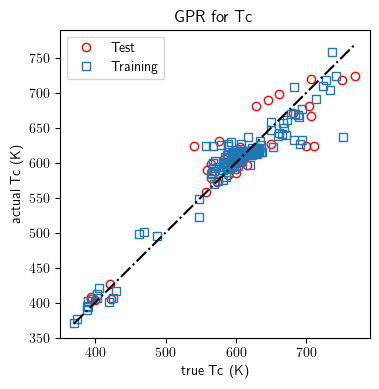

In [ ]:
gpr_tc     = train_model( TCurieData[feature_columns].to_numpy(),
                          TCurieData['Tc (K)'].to_numpy(),
                          model,parameters,
                          verbose = True,
                          xlim    = [350,790],ylim    = [350,790],
                          xlabel  = 'true Tc (K)',ylabel  = 'actual Tc (K)',
                          title   = 'GPR for Tc'
                          )
#gpr_tc[1].best_estimator_.kernel_

Train set: (205, 32) (205,)
Test set: (89, 32) (89,)
tuned hpyerparameters :(best parameters)  {'alpha': 0.0001, 'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1), 'n_restarts_optimizer': 5, 'random_state': 123456}
Test rmse: 0.13020267471502545
Test R2: 0.8282240278836507


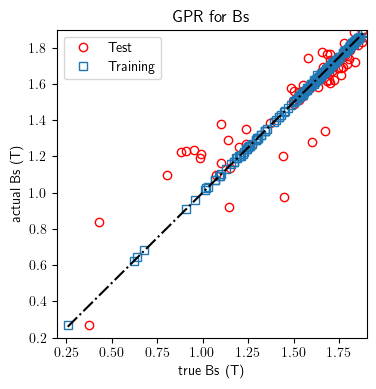

In [ ]:
gpr_bs = train_model( BsData[feature_columns].to_numpy(),
                      BsData['Bs (T)'].to_numpy(),
                      model,parameters,
                      verbose = True,
                      xlim    = [0.2,1.9],ylim    = [0.2,1.9],
                      xlabel  = 'true Bs (T)',ylabel  = 'actual Bs (T)',
                      title   = 'GPR for Bs'
                     )
#gpr_bs[1].best_estimator_.kernel_

### CatBoost


In [ ]:
parameters = {'learning_rate':[0.1],
               'depth':[6],
               'l2_leaf_reg':np.logspace(-1,1,10),
               'rsm':np.linspace(0.0,2.0,10),
               'verbose':[0],
               'random_state':[123456]}

model       = CatBoostRegressor()

Train set: (154, 32) (154,)
Test set: (66, 32) (66,)
tuned hpyerparameters :(best parameters)  {'depth': 6, 'l2_leaf_reg': 3.593813663804626, 'learning_rate': 0.1, 'random_state': 123456, 'rsm': 0.4444444444444444, 'verbose': 0}
Test rmse: 24.044762260665376
Test R2: 0.8844940326632492


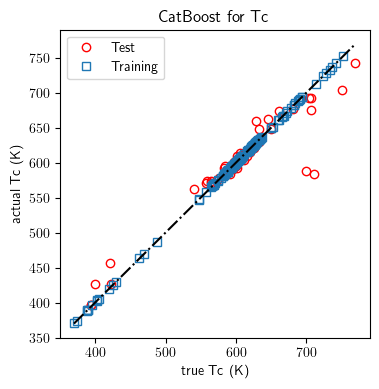

In [ ]:
boost_tc    = train_model(TCurieData[feature_columns].to_numpy(),
                      TCurieData['Tc (K)'].to_numpy(),
                      model,parameters,
                      normalize = False,
                      verbose = True,
                      xlim    = [350,790],ylim    = [350,790],
                      xlabel  = 'true Tc (K)',ylabel  = 'actual Tc (K)',
                      title   = 'CatBoost for Tc'
                      )


Train set: (205, 32) (205,)
Test set: (89, 32) (89,)
tuned hpyerparameters :(best parameters)  {'depth': 6, 'l2_leaf_reg': 5.994842503189409, 'learning_rate': 0.1, 'random_state': 123456, 'rsm': 0.2222222222222222, 'verbose': 0}
Test rmse: 0.11722647146726761
Test R2: 0.8607568020907643


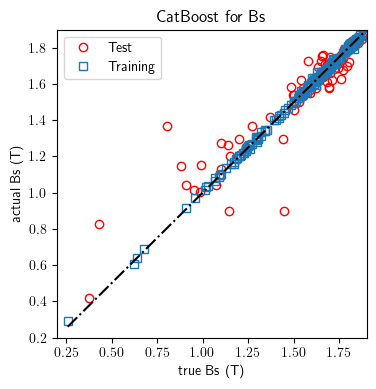

In [ ]:
boost_bs = train_model(BsData[feature_columns].to_numpy(),
                       BsData['Bs (T)'].to_numpy(),
                       model,parameters,
                       normalize = False,
                       verbose = True,
                       xlim    = [0.2,1.9],ylim    = [0.2,1.9],
                       xlabel  = 'true Bs (T)',ylabel  = 'actual Bs (T)',
                       title   = 'CatBoost for Bs'
                      )


### KNN


In [ ]:
parameters = {'n_neighbors': [2, 5, 10, 20],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

model      = KNeighborsRegressor()

Train set: (154, 32) (154,)
Test set: (66, 32) (66,)
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 2, 'p': 2}
Test rmse: 38.688005631944804
Test R2: 0.7009690561824147


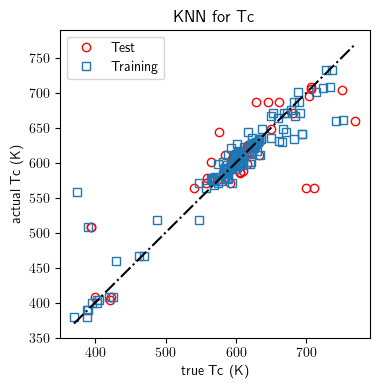

In [ ]:
knn_tc     = train_model(TCurieData[feature_columns].to_numpy(),
                         TCurieData['Tc (K)'].to_numpy(),
                         model,parameters,
                         verbose = True,
                         xlim    = [350,790],ylim    = [350,790],
                         xlabel  = 'true Tc (K)',ylabel  = 'actual Tc (K)',
                         title   = 'KNN for Tc'
                         )


Train set: (205, 32) (205,)
Test set: (89, 32) (89,)
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
Test rmse: 0.1500910878010529
Test R2: 0.7717386331203537


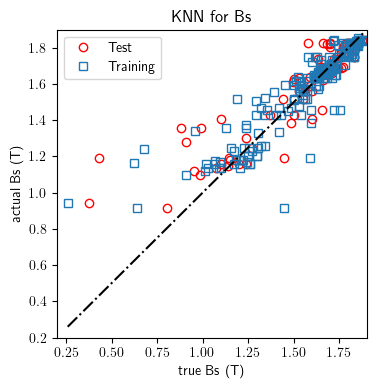

In [ ]:
knn_bs = train_model(BsData[feature_columns].to_numpy(),
                     BsData['Bs (T)'].to_numpy(),
                     model,parameters,
                     verbose = True,
                     xlim    = [0.2,1.9],ylim    = [0.2,1.9],
                     xlabel  = 'true Bs (T)',ylabel  = 'actual Bs (T)',
                     title   = 'KNN for Bs'
                     )


### denseNN

Train set: (154, 32) (154,)
Test set: (66, 32) (66,)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_7                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Test rmse: 28.472048546214182
Test R2: 0.8380425695715383
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


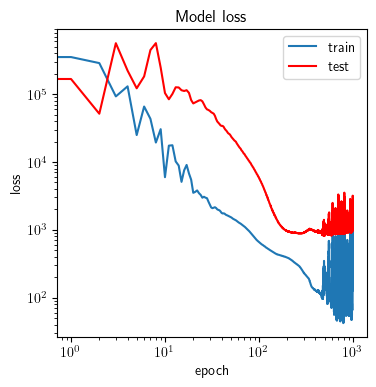

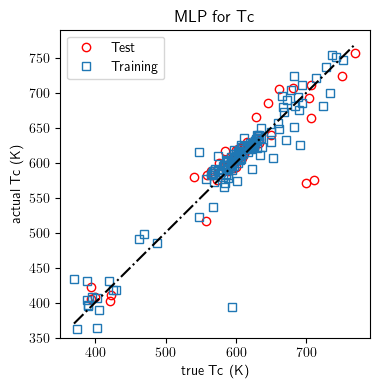

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dense(16, activation='relu'),
                              tf.keras.layers.Dense(8, activation='relu'),
                              tf.keras.layers.Dense(4, activation='relu'),
                              tf.keras.layers.Dense(2, activation='relu'),
                              tf.keras.layers.Dense(1, activation='relu')])

nn_tc = TrainDeepLearnedModel(TCurieData[feature_columns].to_numpy(),
                      TCurieData['Tc (K)'].to_numpy(),
                      model,parameters,
                      verbose = True,
                      save_filename='denseNN_tc.keras',
                      xlim    = [350,790],ylim    = [350,790],
                      xlabel  = 'true Tc (K)',ylabel  = 'actual Tc (K)',
                      title   = 'MLP for Tc')

Train set: (205, 32) (205,)
Test set: (89, 32) (89,)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Test rmse: 0.12211307681255093
Test R2: 0.8489060930370491
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


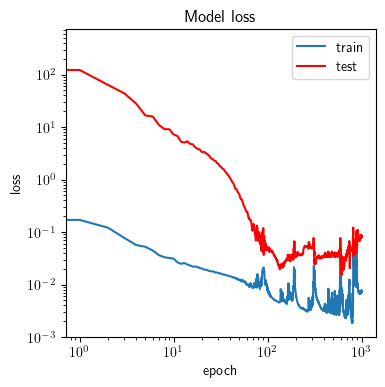

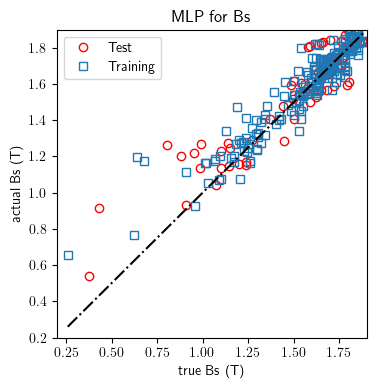

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dense(8, activation='relu'),
                              tf.keras.layers.Dense(4, activation='relu'),
                              tf.keras.layers.Dense(1, activation='relu')])

nn_bs = TrainDeepLearnedModel(BsData[feature_columns].to_numpy(),
                              BsData['Bs (T)'].to_numpy(),
                              model,parameters,
                              verbose=True,
                              save_filename='denseNN_bs.keras',
                              xlim    = [0.2,1.9],ylim    = [0.2,1.9],
                              xlabel  = 'true Bs (T)',ylabel  = 'actual Bs (T)',
                              title   = 'MLP for Bs')

### Models' performance


Here we compare the overall performance of each method based on the $R^2$ metric:


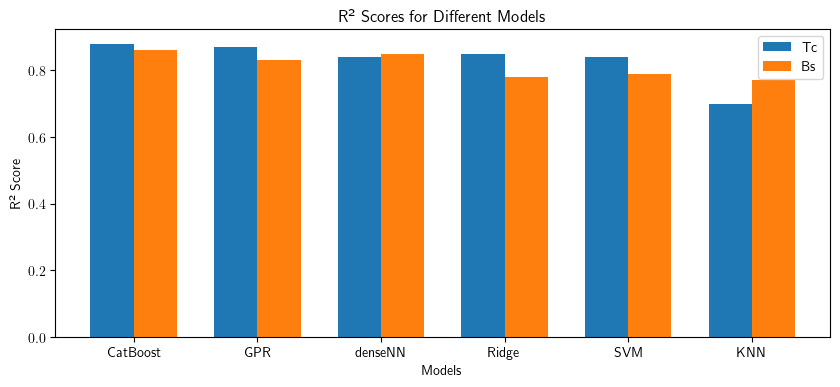

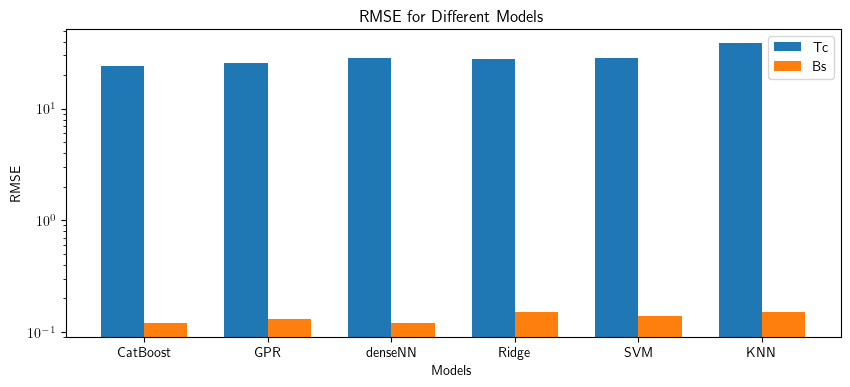

In [ ]:
rsq_metric = {'Ridge':[0.85,0.78],'SVM':[0.84,0.79],'GPR':[0.87,0.83],\
              'CatBoost':[0.88,0.86],'KNN':[0.7,0.77],'denseNN':[0.84,0.85]}

mse_metric = {'Ridge':[27.7,0.15],'SVM':[28.4,0.14],'GPR':[25.8,0.13],\
              'CatBoost':[24.0,0.12],'KNN':[38.7,0.15],'denseNN':[28.5,0.12]}

#models = list(rsq_metric.keys())
for count, metric in enumerate([rsq_metric,mse_metric]):
  if count == 0:
    models = pd.DataFrame(metric).T.mean(axis=1).sort_values(ascending=[False,True][count]).index
  scores = [metric[ml] for ml in models]

  scores = np.array(scores)

  fig, ax = plt.subplots(figsize=(10, 4))

  bar_width = 0.35
  index = np.arange(len(models))

  bar1 = ax.bar(index - bar_width / 2, scores[:, 0], bar_width, label='Tc')
  bar2 = ax.bar(index + bar_width / 2, scores[:, 1], bar_width, label='Bs')

  ax.set_xlabel('Models')
  ax.set_ylabel('R² Score' if count ==0 else 'RMSE')
  ax.set_title('R² Scores for Different Models' if count ==0 else 'RMSE for Different Models')
  ax.set_xticks(index)
  ax.set_xticklabels(models)
  ax.set_yscale('linear' if count ==0 else 'log' )
  ax.legend()



Our performance evaluation indicates that CatBoost and GPR tend to outperform the other models though by a very narrow margin. As shown in the above bar plots, CatBoost achieves the highest R² scores for both `Tc` and `Bs`, with values of 0.88 and 0.86 for these targets. While Ridge Regression, SVM, and dense neural networks also demonstrate relatively good performance, their R² scores are slightly lower, particularly for the Bs predictions. The K-Nearest Neighbors (KNN) model shows the weakest predictive power among the models evaluated.


## Feature importance

We provide a feature importance analysis using SHAP (SHapley Additive exPlanations) and explore how each input feature contributes to the predictions made by the CatBoost model. The SHAP values on the x-axis quantify the impact of each feature on the model's output. A positive SHAP value indicates that the feature contributes positively to the prediction, while a negative SHAP value indicates a negative contribution. The features are listed on the y-axis, ranked from top to bottom by their importance, with the most influential features on top. Each scatter point represents a SHAP value for a single prediction with the color representing the feature value. If red points are clustered on the positive side and blue points on the negative side, this indicates a strong positive contribution of the feature on the prediction (i.e. high `Fe` content improves `Bs`).

In [ ]:
def ShapAnalysis(X,Y,model,**kwargs):
  """
  feature importance analysis using SHAP
  """

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123456)

  explainer   = shap.Explainer( model.predict, X_train )
  shap_values = explainer(X_test)
  shap.summary_plot( shap_values, X_test, feature_names = feature_columns,
                    plot_size=.2,use_log_scale = kwargs.get('use_log_scale',False),
                     )

shap analysis for Tc


PermutationExplainer explainer: 67it [00:26,  1.98it/s]


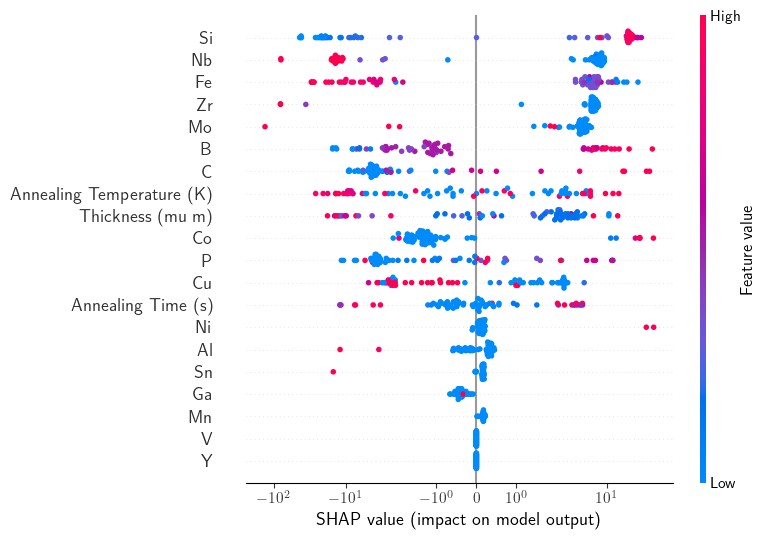

In [ ]:
print('shap analysis for Tc')
ShapAnalysis(TCurieData[feature_columns].to_numpy(),
             TCurieData['Tc (K)'].to_numpy(),
             boost_tc,use_log_scale = True)

shap analysis for Bs


PermutationExplainer explainer: 90it [00:27,  1.93it/s]


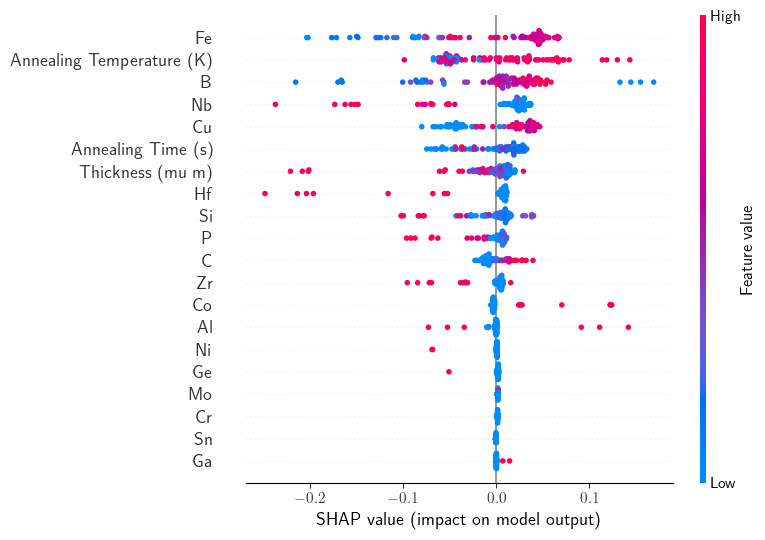

In [ ]:
print('shap analysis for Bs')
ShapAnalysis(BsData[feature_columns].to_numpy(),
             BsData['Bs (T)'].to_numpy(),
             boost_bs)

A few important observations:

* Annealing temperature seems to have a more significant impact on Bs and Tc than annealing time.

* Thinner thicknesses generally enhance the properties.

* Fe has the most significant impact on Bs, showing a positive correlation with concentration, while the former as well as elements like Zr, Mo, and Nb  negatively affect Tc as their concentrations increase.


## Pareto front
We provide the Pareto front for our multi-objective optimization problem.
Initially, we sampled randomly across the feature space based on the dataset's distributions.
The correlation coefficient between the predicted `Tc` and `Bs` values is approximately -0.1 which is fairly weak.
The obtained Pareto front may suggest that improving one target property might not be feasible without compromising the other and, therefore, maximizing both `Bs` and `Tc` simultaneously does not seem very likely.
Nevertheless, the presence of weak correlations might also mean that there might still be a chance to improve both properties.


Correlation coefficient: -0.0477294505952382


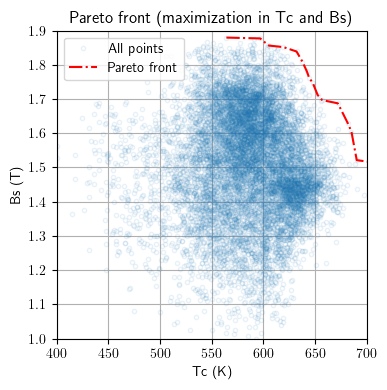

In [ ]:
#--- set 95% quantiles as upper bounds for elemental features
df_merged           = pd.merge(TCurieData,BsData,on=feature_columns,how='outer')
x_features          = df_merged[feature_columns]
quantiles           = x_features.describe(percentiles=[0.05,0.95]).T
percentage_q95      = quantiles['95%'].to_numpy()
percentage_q5       = quantiles['5%'].to_numpy()
#print(np.c_[percentage_q5, percentage_q95])

#--- use the catboost model for predictions
models              = (boost_tc,boost_bs)

#--- sample based on existing distributions
(x,tc,bs)           = Sampling(models,10000, x_features.to_numpy(),
                               percentage_q5,
                               percentage_q95,
                               verbose=False)

#--- plot pareto front
pareto_mask = PlotParetoFront(np.array(tc),np.array(bs),
                xlabel='Tc (K)',ylabel='Bs (T)',
                title = 'Pareto front (maximization in Tc and Bs)',
                xlim=[400,700],ylim=[1.0,1.9],
                grid=True,
                alpha=0.1,
                )

# _ = PlotParetoFront(np.array(tc),np.array(bs),
#                 xlabel='zscored-Tc',ylabel='z-scored Bs',
#                 zscore=True,
#                 xlim=[-4,4],ylim=[-4,4],
#                 grid=True,
#                 alpha=0.1,
#                 )


We suggest a few new alloy compositions across the Pareto front:

In [ ]:
ndime_elemental = len(elemental_features)

new_alloys      = encode_comp.Decode(np.array(x)[:,:ndime_elemental][pareto_mask])
new_process     = np.array(x)[:,ndime_elemental:][pareto_mask]
df_new_alloys   = pd.DataFrame(np.c_[new_alloys,new_process,np.array(tc)[pareto_mask],np.array(bs)[pareto_mask]],\
                               columns = ['Composition']+processing_features+['Tc (K)']+['Bs (T)'])
mask            = df_new_alloys['Annealing Temperature (K)'].astype(float) >0
df_new_alloys[mask][['Composition','Tc (K)',	'Bs (T)']]

,Composition,Tc (K),Bs (T)
1,B11.8Cu0.7Fe81.7Si5.5,641.1412241821384,1.8324089120737577
2,B9.0Cu1.4Fe83.0P1.0Si5.4,610.4007227627761,1.8499346918434576
4,B7.5Co19.5Cu1.0Fe67.2P1.0Si4.0,660.6250979798691,1.674489990180028
8,B9.0Cu1.0Fe84.0Si6.1,602.2282859762865,1.865081026192204
10,B10.0C4.0Cu1.0Fe80.4Si5.0,629.2908418088338,1.8494460184676083
11,B9.0Cu0.7Fe85.0Si5.0,600.5693786821497,1.8908994199307874
12,B8.0C9.0Cu1.3Fe74.2P2.8Si5.1,668.5515731870305,1.6356418943745337
13,B13.0Fe82.0Si5.1,646.8475240332217,1.7674778885718634
14,B11.0Cu1.0Fe80.0Si8.3,649.9077957178928,1.734410312315357
16,B8.0C4.0Cu1.0Fe81.2Si6.0,629.3856258323906,1.841386918758341


## Bayesian optimization
Here the alloy compositions were optimized using a Bayesian framework implemented in the Optuna library. The optimization was initiated by analyzing the existing data points as a prior distribution. An acquisition function was then utilized to evaluate the prior distribution and identify the location with the highest probability of extreme values for subsequent testing. The results from these tests were used to update the posterior distribution, which further served as the prior for the next iteration. The optimization problem in this study can be described as:

Maximize {`Tc`, `Bs`} = f(`Al`, `B`, ..., `Fe`, ..., `Zr`)

Subject to:

0≤`Al`≤3,  0≤`B`≤15,  ...,  0≤`Fe`≤85,  0≤`Zr`≤1 at %,

`Al`+`B`+...+`Fe`+...+`Zr` = 100 at %,

`Annealing Time (s)` = 600,

`Annealing Temperature (K)` = 660,

`Thickness (mu m)`=21.





The final CatBoost model, denoted as f, was utilized to initiate the iterative  process once the optimization direction (i.e. maximization in both `Tc`, `Bs`) and range were specified. The content ranges for each alloy element were initially set based on the dataset's distribution. In this context, we chose the 95% quantile as an upper bound for each element. The process parameters (`Annealing Time (s)`, `Annealing Temperature (K)`, `Thickness (mu m)`) were selected as the most commonly used parameters in our dataset (i.e. the median values).

In [ ]:
#--- set 95% quantiles as upper bounds for elemental features
df_merged           = pd.merge(TCurieData,BsData,on=feature_columns,how='outer')
quantiles           = df_merged[elemental_features].describe(percentiles=[0.95]).T
elem_percentage_q95 = quantiles['95%'].to_numpy()

In [ ]:
#--- use the catboost model for predictions
models = (boost_tc,boost_bs)

In [ ]:
df_merged           = pd.merge(TCurieData,BsData,on=feature_columns,how='outer')
X_samples          = df_merged[feature_columns].to_numpy()
X_samples.shape

(489, 32)

We simulate the Bayesian optimizer using 10,000 trials.  

In [ ]:
def objective( trial ):
    """
    objective function for optuna
    """

    #--- Create a feature vector based on the suggested parameters

    x_elemental    = np.array([trial.suggest_float('%s'%elem, 0.0, elem_percentage_q95[idime]) for idime, elem  in enumerate(elemental_features)]).reshape(1, -1)
#    x_elemental    = np.array([trial.suggest_categorical('%s'%elem, X_samples[:,idime]) for idime, elem  in enumerate(elemental_features)]).reshape(1, -1)
    #
    annealing_time = 600.0
    annealing_temp = 660.0
    thickness      = 21.0
    x_processing   = np.array([annealing_time,annealing_temp,thickness]).reshape(1, -1)
    #
    feature_vector = np.hstack([x_elemental,x_processing])

    #--- Constraint: The sum of elemental parameters must be 1
    param_sum      = np.sum(x_elemental)
#    print(f'Sum of elemental parameters: {param_sum}')


    #--- penalty if the sum deviates from 1
    if not np.isclose(param_sum, 100.0, atol=0.5):
        raise optuna.exceptions.TrialPruned(f'Sum constraint not met: {param_sum}')

    #--- prediction using the trained model
    tc             = models[ 0 ].predict(feature_vector)[0]
    bs             = models[ 1 ].predict(feature_vector)[0]

    return tc, bs

In [ ]:
#--- the Optuna study for multi-objective optimization
study = optuna.create_study(
                             directions = ["maximize", "maximize"],  # Maximize both BS and TC
                             sampler    = NSGAIISampler()  # Use NSGA-II sampler
                           )

#--- Optimize the study
study.optimize(objective,
               n_trials         =40000,
               show_progress_bar=True,
               n_jobs           =4)

#--- the set of optimal solutions
pareto_front = study.best_trials

  0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
# posterior_dist = []
# bs_values = []
# tc_values = []
# for trial in study.trials:
#     if trial.values is not None:
#         item = list(map(lambda x:trial.params.get(x),elemental_features))
#         posterior_dist.append(item)
#         bs_values.append(trial.values[1])
#         tc_values.append(trial.values[0])

# df_posterior = pd.DataFrame(np.array(posterior_dist),columns=elemental_features)

# sns.histplot(data=df_merged,x='Fe',kde=True,stat='density')
# sns.histplot(data=df_posterior,x='Fe',kde=True,stat='density')
# plt.legend(['prior','posterior'])

In this scatter plot, the optimal solutions sampled by the optimization process correspond to denser regions in the space.

Number of accepted trials: 8119
Number of accepted trials: 8119


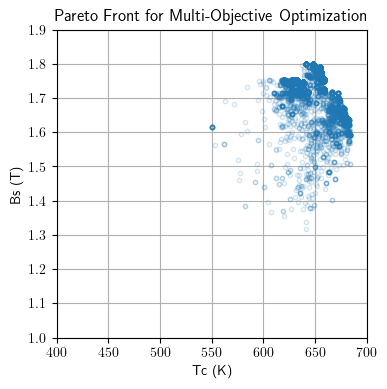

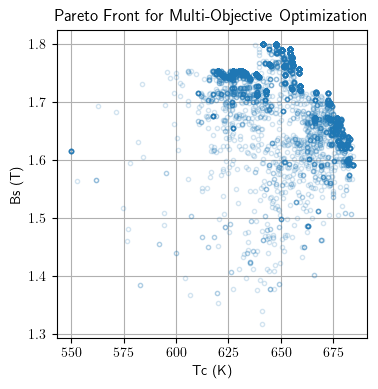

In [ ]:
df_pareto = PlotOptunaResults(study,
                xlabel='Tc (K)',ylabel='Bs (T)',
                title = 'Pareto Front for Multi-Objective Optimization',
                xlim=[400,700],ylim=[1.0,1.9],
                alpha=0.2,
                plot_pareto = False,
                  grid=True
                  )

_ = PlotOptunaResults(study,
                xlabel='Tc (K)',ylabel='Bs (T)',
                title = 'Pareto Front for Multi-Objective Optimization',
                # xlim=[400,700],ylim=[1.0,1.9],
                alpha=0.2,
                plot_pareto = False,
                  grid=True
                  )

# _=PlotParetoFront(x_sampled,boost_tc,boost_bs,
#                 xlabel='Tc (K)',ylabel='Bs (T)',
#                 title = 'Pareto Front (Maximization)',
#                 xlim=[350,790],ylim=[0.2,1.9],
#                   grid=True,
#                   alpha=0.1
#                 )

In [ ]:
x               = df_pareto[elemental_features].to_numpy()

new_alloys      = encode_comp.Decode(x)
df_new_alloys   = pd.DataFrame(np.c_[np.array(new_alloys),df_pareto.tc,df_pareto.bs],\
                                columns = ['Composition']+['Tc (K)']+['Bs (T)'])
df_new_alloys.drop_duplicates(subset=['Composition']).sort_values(by=['Bs (T)'],ascending=False).reset_index(drop=True).sample(10)

,Composition,Tc (K),Bs (T)
5,B11.9Co4.8Fe76.8Si4.9,647.5237775541214,1.7990051070016562
21,Al1.9B12.3C2.4Co5.9Fe64.5P5.9Si5.3,674.414985246401,1.6921581148036269
1,B11.9C1.0Co4.8Fe76.8Si4.8,647.5237775541214,1.7990051070016562
15,B12.3C5.3Co5.9Fe64.5P4.6Si5.3,672.5390501706607,1.7146745937730183
7,B11.9Co4.8Fe76.8Si5.5,658.5248981549697,1.7568131738050443
40,B12.1C3.2Co5.0Fe64.5P4.5Si9.0,681.9211871281688,1.6387949300207756
11,B12.1Co4.8Fe76.8Si5.3,658.9351362358532,1.727473127183303
0,B11.9Co4.7Fe76.8Si4.8,641.41942132558,1.8005473708924467
43,Al1.9B12.3Co5.9Fe64.5P4.5Si9.0,683.6202746967599,1.6240796706965965
22,B12.3C2.4Co5.9Fe64.5P5.9Si6.9,674.9090198916298,1.6787346329651023


## Uncertainty/sensitivity analysis
We employ the Bayesian framework to assess uncertainties in `BS` due to fluctuations in `Fe` content within the alloy `Fe83B9Si5P3`.
To obtain the posterior distribution of the `Fe` composition
given the observed quantity $B^{obs}_s$, we utilyze the Bayes theorem:

$p(Fe|B^{obs}_s )\propto p(B^{obs}_s|Fe)~ p(Fe)$,

with the prior distribution $p(Fe)$.

We also assume the likelihood function with the following form:

$p(B^{obs}_s|Fe) \propto exp[-\{B^{obs}_s-\mu_\text{GPR}(Fe)\}^2\times\sigma_\text{GPR}^{-2}(Fe)]$,

where $\mu_\text{GPR}$ and $\sigma_\text{GPR}^{-2}$ correspond to the GPR's prediction and variance.

We further consider the `Fe`'s prior distribution to be a uniform distribution over a relevant range (i.e. around 83%).
`B` is also deterministically calculated as 92 - `Fe` to ensure that the total concentration adds up to 100 (combined with `Si`=5 and `P`=3). We set `Annealing Time (s)`=600,	`Annealing Temperature (K)`=647, and `Thickness (mu m)`=20 which correspond to the experimental values associated with `Fe83B9Si5P3`.

In [ ]:
BsData[BsData['Composition'] == 'Fe83B9Si5P3']

,Composition,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Bs (T),Al,B,C,Co,Cr,...,Pr,Sb,Si,Sm,Sn,Ta,Tb,V,Y,Zr
171,Fe83B9Si5P3,600,647.0,20.0,1.68,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A simple sampling scheme is employed below to compute the posterior distribution of Fe. We combine the prior and the likelihood to obtain the latter. We further set $B^{obs}_s$ to the observed experimental value 1.68 T.

In [ ]:
class Uncertainty:
  """
  Uncertainty/sensitivity analysis
  """

  def __init__(self, model, **kwargs):
      self.model          = model
      self.bs_observed    = kwargs.get('bs_observed', 1.0) #--- observed Bs value (in Tesla)
      self.annealing_time = kwargs.get('annealing_time', 600.0)
      self.annealing_temp = kwargs.get('annealing_temp',647.0)
      self.thickness      = kwargs.get('thickness',20.0) #--- thickness (in mu)

  def GenerateFeSamples(self, rng,num_samples):
    #--- generate samples of Fe composition
    self.fe_samples = rng.rvs(size= num_samples)


  def FeatureVector(self):
      #--- create a feature vector based on the relevant parameters
      num_samples = self.fe_samples.shape[0]
      alloys   = ['Fe%.1fB%.1fSi5.0P3.0'%(fe,100.0 - fe - 5.0 - 3.0) for fe in self.fe_samples ]
      x_elemental, _ = encode_comp.Encode(pd.Series(alloys),elements_dic=elements_combined)
      x_processing   = np.array([self.annealing_time,self.annealing_temp,self.thickness]*num_samples).reshape(-1, 3)
      return np.hstack([x_elemental,x_processing])

  def Trials(self,num_trials,nevery=200):
    #--- sample posterior distribution of Fe

    self.prior = self.fe_samples.copy()
    #--- sampling loop
    for i in range(num_trials):
      print('trial:',i)
      feature_vector = self.FeatureVector()
      #--- likelihood
      x_transform = self.model[0].transform(feature_vector)
      self.mu, sigma = self.model[1].best_estimator_.predict(x_transform,return_std=True)
      # print('mu, sigma:',mu,sigma)
      x = ( self.mu - self.bs_observed )/sigma
      likelihood = np.exp(-x*x)

      #--- normalization
      likelihood /= np.sum(likelihood)

      #--- sampling
      x = np.random.choice(self.fe_samples, size=1, p=likelihood)

      #--- append to the existing samples
      self.fe_samples = np.concatenate([self.fe_samples,x])

      if i%nevery==0:
        sns.kdeplot(self.fe_samples,label='posterior distribution:%s'%i)

    plt.legend()
    self.posterior = self.fe_samples.copy()

Streaming output truncated to the last 5000 lines.
trial: 3000
trial: 3001
trial: 3002
trial: 3003
trial: 3004
trial: 3005
trial: 3006
trial: 3007
trial: 3008
trial: 3009
trial: 3010
trial: 3011
trial: 3012
trial: 3013
trial: 3014
trial: 3015
trial: 3016
trial: 3017
trial: 3018
trial: 3019
trial: 3020
trial: 3021
trial: 3022
trial: 3023
trial: 3024
trial: 3025
trial: 3026
trial: 3027
trial: 3028
trial: 3029
trial: 3030
trial: 3031
trial: 3032
trial: 3033
trial: 3034
trial: 3035
trial: 3036
trial: 3037
trial: 3038
trial: 3039
trial: 3040
trial: 3041
trial: 3042
trial: 3043
trial: 3044
trial: 3045
trial: 3046
trial: 3047
trial: 3048
trial: 3049
trial: 3050
trial: 3051
trial: 3052
trial: 3053
trial: 3054
trial: 3055
trial: 3056
trial: 3057
trial: 3058
trial: 3059
trial: 3060
trial: 3061
trial: 3062
trial: 3063
trial: 3064
trial: 3065
trial: 3066
trial: 3067
trial: 3068
trial: 3069
trial: 3070
trial: 3071
trial: 3072
trial: 3073
trial: 3074
trial: 3075
trial: 3076
trial: 3077
trial: 3078
t

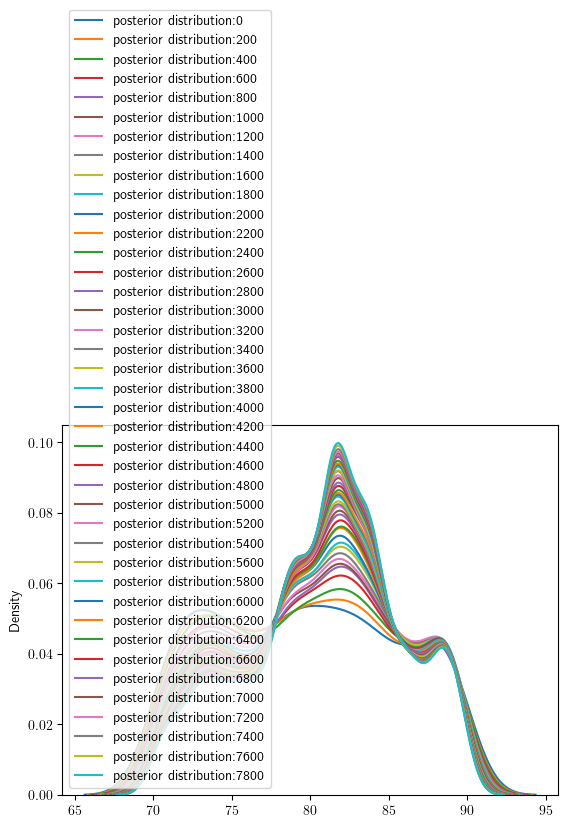

In [ ]:
uq = Uncertainty( gpr_bs,
                  bs_observed = 1.68)

uq.GenerateFeSamples(
                     stats.uniform(loc=70, scale=20), #np.random.normal(loc=83.0, scale=3.0, size=num_samples) #np.random.uniform(80,86,num_samples)
                     num_samples=1000,
                     )

uq.Trials(num_trials  = 8000)

In [ ]:
# ys_pred=[]
# ys_std=[]
# for fe in uncertainty_obj.fe_samples:
#       alloy   = pd.Series(['Fe%.1fB%.1fSi5.0P3.0'%(fe,100.0 - fe - 5.0 - 3.0)])
#       x       = uncertainty_obj.FeatureVector(alloy)
#       x_transform = uncertainty_obj.model[0].transform(x)
#       # y_pred.append(uncertainty_obj.model.predict(x)[0])

#       ypred, y_std = uncertainty_obj.model[1].best_estimator_.predict(x_transform,return_std=True)
#       ys_pred.append(ypred[0])
#       ys_std.append(y_std[0])
# ys_pred = np.array(ys_pred)
# ys_std  = np.array(ys_std)
# X_samples = uncertainty_obj.fe_samples
# #print(np.c_[ys_pred,ys_std])
# uncertainty_obj.Prior_Fe_distribution(83,1.0
#                                       ) #80.0,86.0)


The figure below shows the posterior distribution of `Fe` (black dashdotted curve) as well as the prior and true (underlying) distributions.

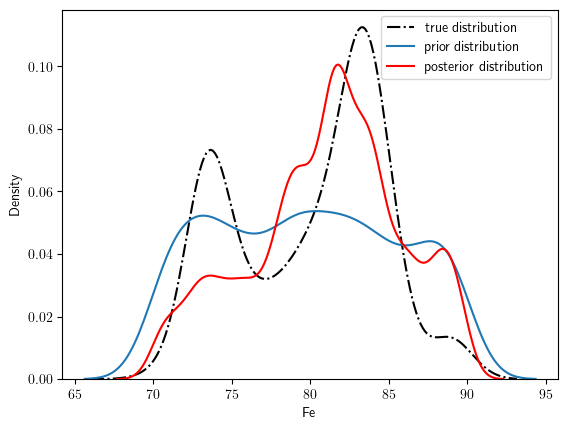

In [ ]:
df_merged  = pd.merge(TCurieData,BsData,on=feature_columns,how='outer')
filtr1     = df_merged[elemental_features]['Fe']>=uq.posterior.min()
filtr2     = df_merged[elemental_features]['Fe']<=uq.posterior.max()

sns.kdeplot(df_merged[filtr1 & filtr2]['Fe'],linestyle='-.', color='black', label='true distribution')
sns.kdeplot(uq.prior,label='prior distribution')
sns.kdeplot(uq.posterior,label='posterior distribution',color='red')
plt.legend()

Here is the box plot of Bs associated with 4000 random sample points drawn from the posterior distribution of Fe.

Mean BS: 1.6226810935584108
Standard Deviation of BS: 0.0475097405187909
90% Confidence Interval for BS: [1.53496435 1.68049446]


<Axes: >

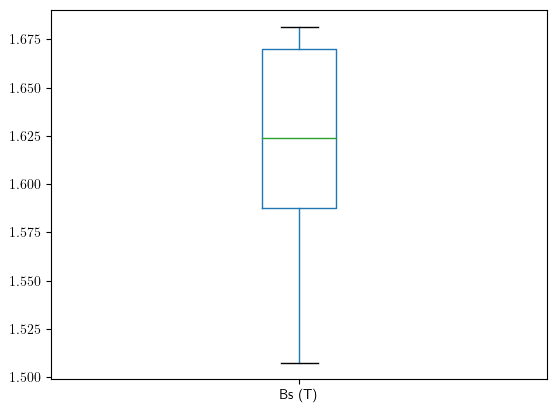

In [ ]:
mean_bs = np.mean(uq.mu)
std_bs = np.std(uq.mu)
ci_bs = np.percentile(uq.mu, [5, 95])

print('Mean BS:', mean_bs)
print('Standard Deviation of BS:', std_bs)
print('90% Confidence Interval for BS:',ci_bs)

pd.DataFrame(uq.mu,columns=['Bs (T)']).boxplot(grid=False)

In [ ]:
# plt.scatter(df_merged['Fe'],df_merged['Bs (T)'])

# x=df_merged[feature_columns].to_numpy()
# y_pred = gpr_bs.predict(x)
# fe=df_merged['Fe'].to_numpy()
# data = pd.DataFrame(np.c_[fe,y_pred],columns=['x','y']).sort_values(by='x')

# plt.plot(data.x,data.y,color='red')

# plt.plot()
# plt.xlim(82,84)
# plt.ylim(1,2)

In [ ]:
# # Bayesian model
# X = BsData[feature_columns].to_numpy()
# Y = BsData['Bs (T)'].to_numpy()
# _, _, y_train, _ = train_test_split(X, Y, test_size=0.3, random_state=123456)

# with pm.Model() as model:

#     # Priors for the unknown parameters
#     Fe = pm.Uniform('Fe', lower=80, upper=86)

#     # Define the GP prior
#     mean_gp = Fe #np.interp(Fe, X_samples.flatten(), ys_pred)
#     std_gp = Fe #np.interp(Fe, X_samples.flatten(), ys_std)

#     # Likelihood (sampling distribution) of observations
#     y_obs = pm.Normal('y_obs', mu=mean_gp, sigma=std_gp, observed=y_train)

#     # Sample from the posterior
#     trace = pm.sample(1000, chains=2, return_inferencedata=False)

# # Summarize the results
# #pm.summary(trace)


In [ ]:
# # Bayesian model
# X = BsData[feature_columns].to_numpy()
# Y = BsData['Bs (T)'].to_numpy()
# _, _, Y_train, _ = train_test_split(X, Y, test_size=0.3, random_state=123456)


# with pm.Model() as model:

#     # Prior for the unknown parameter Fe
#     Fe = pm.Uniform('Fe', lower=80, upper=86)
#     B = pm.Deterministic('B', 92 - Fe)  # B is determined by Fe
#     Si = pm.Uniform('Si', lower=5, upper=5)
#     P = pm.Uniform('P', lower=3, upper=3)
#     zero_val = pm.Uniform('zero', lower=0, upper=0)
#     tensor_array = []

# #    Create the elemental feature vector (19 components)
#     ndime = len(elemental_features)
#     for i in range(ndime):
#       elem = encode_comp.element_inverse[i]
#       if elem == 'Fe':
#         var = Fe
#       elif elem == 'B':
#         var = B
#       elif elem == 'Si':
#         var = Si
#       elif elem == 'P':
#         var = P
#       else:
#         var = zero_val
#       tensor_array.append(var)


#     annealing_time = pm.Uniform('annealing_time',lower=600.0,upper=600.0)
#     tensor_array.append(annealing_time)
#     annealing_temp = pm.Uniform('annealing_temp',lower=647.0,upper=647.0)
#     tensor_array.append(annealing_temp)
#     thickness      = pm.Uniform('thickness',lower=20.0,upper=20.0)
#     tensor_array.append(thickness)
#     print('tensor_array=',tensor_array)


#     # Combine elemental and process features
#     feature_vector = pm.math.stack(tensor_array, axis=0)
#     print(feature_vector.shape)

#     # Use GPR to predict mean and standard deviation
# #    x_transform = gpr_bs[0].transform(feature_vector)

#     mean_gp, std_gp = gpr_bs[1].best_estimator_.predict(feature_vector, return_std=True)

#     # # Likelihood (sampling distribution) of observations
#     # y_obs = pm.Normal('y_obs', mu=mean_gp, sd=std_gp, observed=Y_train)

#     # # Sample from the posterior, using two chains
#     # trace = pm.sample(80000, chains=2, return_inferencedata=False, tune=1000)

# # Assessing convergence
# # Plotting the trace
# # pm.traceplot(trace, var_names=['Fe', 'B'])
# # plt.show()

# # # Gelman-Rubin statistic (R-hat)
# # rhat = pm.rhat(trace)
# # print(f'R-hat for Fe: {rhat["Fe"]}')
# # print(f'R-hat for B: {rhat["B"]}')

# # # Summary of the trace
# # summary = pm.summary(trace, var_names=['Fe', 'B'])
# # print(summary)


# # # Assessing convergence
# # # Plotting the trace
# # pm.traceplot(trace, var_names=['Fe'])
# # plt.show()

# # # Gelman-Rubin statistic (R-hat)
# # rhat = pm.rhat(trace)['Fe']
# # print(f'R-hat for Fe: {rhat}')

# # # Summary of the trace
# # summary = pm.summary(trace, var_names=['Fe'])
# # print(summary)

## Optimization with constraints


We introduce an additional dataset containing the onset crystallization temperature (Tx) values.
First, we train a new CatBoost regressor to predict Tx using the provided elemental compositions and processing parameters as input features.



Train set: (165, 32) (165,)
Test set: (72, 32) (72,)
tuned hpyerparameters :(best parameters)  {'depth': 6, 'l2_leaf_reg': 1.291549665014884, 'learning_rate': 0.1, 'random_state': 123456, 'rsm': 0.6666666666666666, 'verbose': 0}
Test rmse: 12.106637935060718
Test R2: 0.9771554725383106


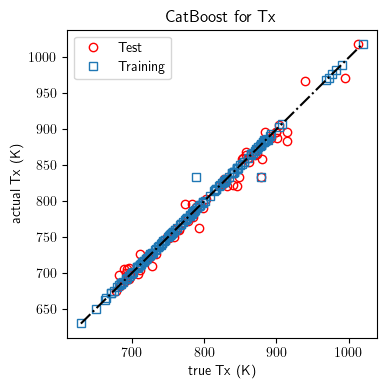

In [ ]:
parameters = {'learning_rate':[0.1],
               'depth':[6],
               'l2_leaf_reg':np.logspace(-1,1,10),
               'rsm':np.linspace(0.0,2.0,10),
               'verbose':[0],
               'random_state':[123456]}

model       = CatBoostRegressor()

boost_tx    = train_model(TxData[feature_columns].to_numpy(),
                      TxData['Tx/K'].to_numpy(),
                      model,parameters,
                      normalize = False,
                      verbose = True,
#                      xlim    = [350,790],ylim    = [350,790],
                      xlabel  = 'true Tx (K)',ylabel  = 'actual Tx (K)',
                      title   = 'CatBoost for Tx'
                      )



In [ ]:
#--- set 95% quantiles as upper bounds for elemental features
df_merged           = pd.merge(TCurieData,BsData,on=feature_columns,how='outer')[feature_columns]
df_merged_2nd       = pd.merge(df_merged,TxData[feature_columns],on=feature_columns,how='outer')
quantiles           = df_merged_2nd[elemental_features].describe(percentiles=[0.05,0.95]).T
elem_percentage_q95 = quantiles['95%'].to_numpy()
elem_percentage_q5 = quantiles['5%'].to_numpy()

In [ ]:
#--- use the catboost model for predictions
models = (boost_tc,boost_bs, boost_tx)

We then incorporate this trained Tx model as part of the constrained optimization process, where Tx is constrained to remain between 600 and 800 K.
We refine our existing optimization code to include this new constraint.



In [ ]:
def objective_refined( trial ):
    """
    objective function for optuna
    """

    #--- Create a feature vector based on the suggested parameters

    x_elemental    = np.array([trial.suggest_float('%s'%elem, elem_percentage_q5[idime], elem_percentage_q95[idime]) for idime, elem  in enumerate(elemental_features)]).reshape(1, -1)
#    x_elemental    = np.array([trial.suggest_categorical('%s'%elem, X_samples[:,idime]) for idime, elem  in enumerate(elemental_features)]).reshape(1, -1)
    #
    annealing_time = 600.0
    annealing_temp = 660.0
    thickness      = 21.0
    x_processing   = np.array([annealing_time,annealing_temp,thickness]).reshape(1, -1)
    #
    feature_vector = np.hstack([x_elemental,x_processing])

    #--- Constraint: The sum of elemental parameters must be 1
    param_sum      = np.sum(x_elemental)


    #--- penalty if the sum deviates from 1
    if not np.isclose(param_sum, 100.0, atol=0.5):
        raise optuna.exceptions.TrialPruned(f'Sum constraint not met: {param_sum}')
    #--- additional constraint
    tx             = models[ 2 ].predict(feature_vector)[0]
    constraint2nd =  600.0 < tx < 800.0
    if not constraint2nd:
        raise optuna.exceptions.TrialPruned(f'Tx constraint not met: {param_sum}')

    print(f'Sum of elemental parameters: {param_sum}, Tx:{tx}')

    #--- prediction using the trained model
    tc             = models[ 0 ].predict(feature_vector)[0]
    bs             = models[ 1 ].predict(feature_vector)[0]

    return tc, bs




In [ ]:
#--- the Optuna study for multi-objective optimization
study = optuna.create_study(
                             directions = ["maximize", "maximize"],  # Maximize both BS and TC
                             sampler    = NSGAIISampler()  # Use NSGA-II sampler
                           )


#--- Optimize the study
study.optimize(objective_refined, n_trials=30000,show_progress_bar=True, n_jobs=4)

#--- the set of optimal solutions
pareto_front = study.best_trials

  0%|          | 0/30000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Sum of elemental parameters: 99.53702938524845, Tx:762.6115244506411
Sum of elemental parameters: 99.56446618523846, Tx:758.7542018737689
Sum of elemental parameters: 100.4981426147926, Tx:765.8438215552413
Sum of elemental parameters: 99.96618333895556, Tx:762.6115244506411
Sum of elemental parameters: 100.11678950998785, Tx:765.8438215552413
Sum of elemental parameters: 100.0333577818544, Tx:765.8438215552413
Sum of elemental parameters: 100.47047050710472, Tx:766.6858535517702
Sum of elemental parameters: 100.23979082391592, Tx:764.1458340834259Sum of elemental parameters: 100.05676516842193, Tx:765.8438215552413

Sum of elemental parameters: 100.10439623156408, Tx:765.8837036472366
Sum of elemental parameters: 100.05676516842193, Tx:765.8438215552413
Sum of elemental parameters: 99.65356800218204, Tx:762.6115244506411Sum of elemental parameters: 100.20405752387775, Tx:765.8438215552413

Sum of elemental parameters: 100.116201216292

In [ ]:
# posterior_dist = []
# bs_values = []
# tc_values = []
# for trial in study.trials:
#     if trial.values is not None:
#         item = list(map(lambda x:trial.params.get(x),elemental_features))
#         posterior_dist.append(item)
#         bs_values.append(trial.values[1])
#         tc_values.append(trial.values[0])


# df_posterior = pd.DataFrame(np.array(posterior_dist),columns=elemental_features)

# sns.histplot(data=df_merged,x='Fe',kde=True,stat='density')
# sns.histplot(data=df_posterior,x='Fe',kde=True,stat='density')



We provide the optimized alloy compositions that satisfy the Tx constraint relevant to the original objectives (Bs and Tc).
Finally, we generate and present the updated Pareto front considering this new constraint on Tx.


Number of accepted trials: 8304


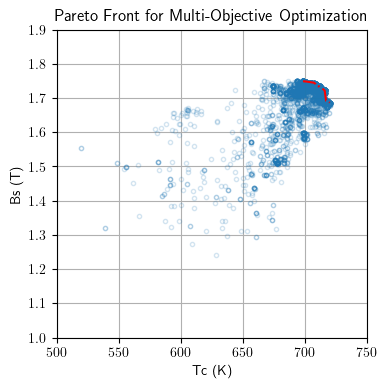

In [ ]:
df_pareto = PlotOptunaResults(study,
                xlabel='Tc (K)',ylabel='Bs (T)',
                title = 'Pareto Front for Multi-Objective Optimization',
                xlim=[500,750],ylim=[1.0,1.9],
                alpha=0.2,
                pareto_front = True,
                  grid=True,
                  )


In [ ]:
x               = df_pareto[elemental_features].to_numpy()

new_alloys      = encode_comp.Decode(x)
df_new_alloys   = pd.DataFrame(np.c_[np.array(new_alloys),df_pareto.tc,df_pareto.bs],\
                                columns = ['Composition']+['Tc (K)']+['Bs (T)'])
df_new_alloys.drop_duplicates(subset=['Composition']).sort_values(by=['Bs (T)'],ascending=False).reset_index(drop=True)

,Composition,Tc (K),Bs (T)
0,B12.2C1.4Co16.5Fe58.1Ni2.7P1.4Si5.3,698.58969616039,1.7490266616099208
1,B12.2C1.3Co16.5Fe56.9Ni3.3P1.4Si5.3,698.58969616039,1.7490266616099208
2,B12.2C1.4Co16.5Fe56.9Ni3.4P1.4Si5.3,698.58969616039,1.7490266616099208
3,B12.2C1.4Co16.5Fe56.9Ni3.3P1.3Si5.3,698.58969616039,1.7490266616099208
4,B12.2C1.4Co16.5Fe57.4Ni3.3P1.2Si5.3,698.58969616039,1.7490266616099208
...,...,...,...
110,B12.9Co16.5Fe57.4Ga1.8Ni3.3Si6.4,720.1043603573714,1.686542805091791
111,B12.9Co16.5Fe58.1Ga1.0Ni3.3Si6.4,720.1043603573714,1.686542805091791
112,B12.9Co16.5Fe58.1Ga1.3Ni3.0Si6.4,720.1043603573714,1.686542805091791
113,B12.9Co16.5Fe56.9Ga1.8Ni3.3Si6.4,720.1043603573714,1.686542805091791


In [ ]:
#df_tmp = round(df_new_alloys.drop_duplicates(subset=['Composition']).sort_values(by=['Bs (T)'],ascending=False).reset_index(drop=True)[['Tc (K)',	'Bs (T)']].astype(float),2)
#ss = df_new_alloys.drop_duplicates(subset=['Composition']).sort_values(by=['Bs (T)'],ascending=False).reset_index(drop=True)['Composition']
#pd.DataFrame(np.c_[ss,df_tmp],columns=['Composition','Tc (K)','Bs (T)']).sample(10)